In [1]:
install.packages("glmnet")
install.packages("caret")
install.packages("dplyr")
install.packages("pROC")
install.packages("rsample")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpdLXewk/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpdLXewk/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpdLXewk/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpdLXewk/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpdLXewk/downloaded_packages


In [2]:
library(glmnet)
library(caret)
library(dplyr)
library(pROC)
library(rsample)

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




# Import and format data

In [36]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
data$scaled_score <- data$score_min/5
data$logistic_transformed_score <- plogis(data$scaled_score)
trim_data <- data %>% select(-identifier,-score_min, - scaled_score,  -serviceable_agg, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)

build a model

In [9]:
model <- lm(logistic_transformed_score ~ predictors, data = data)


# Approach 1: Setting alpha manually

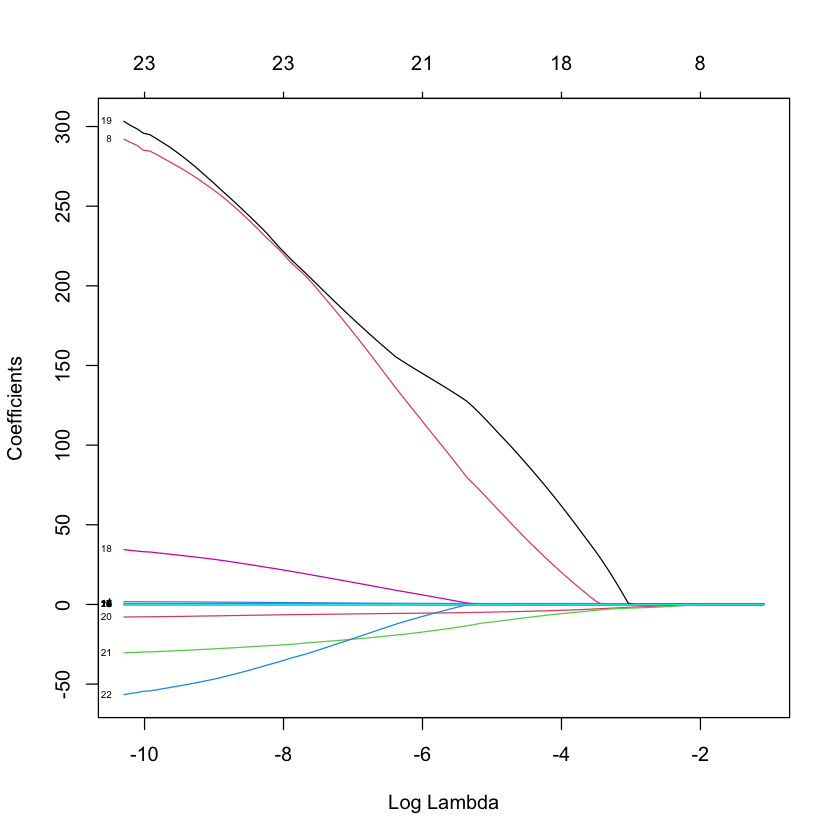

24 x 1 sparse Matrix of class "dgCMatrix"
                                                              s0
(Intercept)                                        -1.960886e+00
IT01V_packetsRecieved_ellen                         .           
IT01V_packetsLost_ellen                             .           
IT01V_frameWidth_ellen                              2.547197e-04
IT01V_totalFreezesDuration_ellen                    .           
IT01V_framesPerSecond_ellen                         1.904645e-02
IT01V_bytesReceived_in_bits_s_ellen                 .           
IT01V_totalProcessingDelay_ellen                    .           
IT01V_jitter_ellen                                  .           
IT01V_jitterBufferDelay_emissions_ellen             .           
IT01A_bytesReceived_in_bits_s_ellen                 .           
IT01A_jitterBufferDelay_emissions_ellen             .           
OT01V_packetsSent_s_ellen                           2.217127e-03
OT01V_bytesSent_in_bits_s_ellen                 

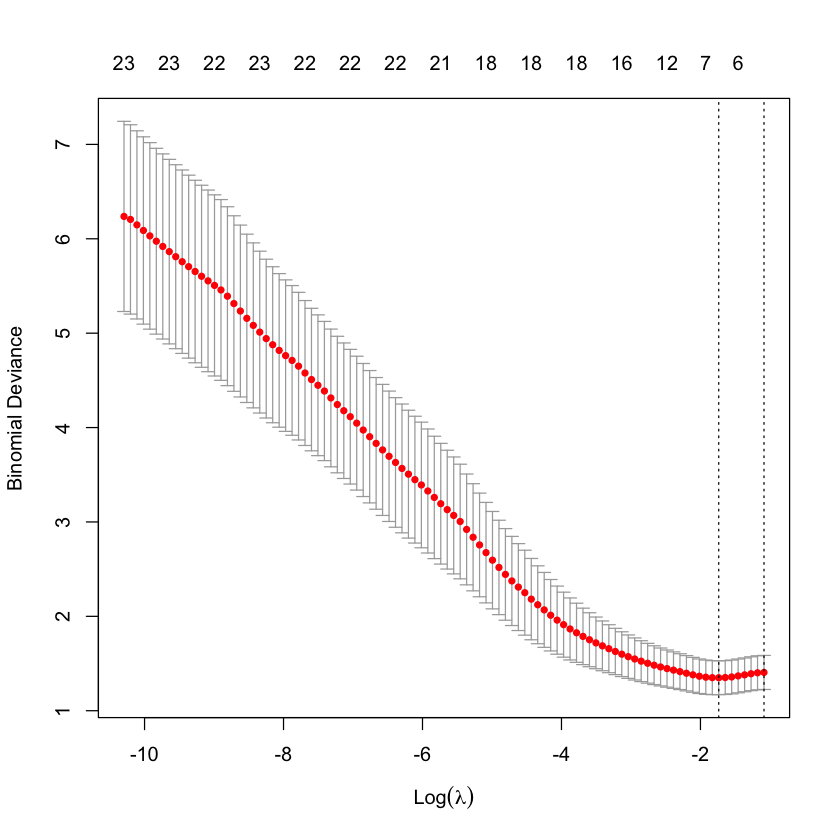

In [57]:
# alpha = 0.5(elastic net)
par(bg= "white")
model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the coefficient paths
plot(model_manual, xvar = "lambda", label = TRUE)

# Perform cross-validation to find the optimal lambda
cv_model_manual <- cv.glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the cross-validation curve
plot(cv_model_manual)

# Get the best lambda
best_lambda <- cv_model_manual$lambda.min

# Fit the final model with the best lambda
final_model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5, lambda = best_lambda)

# Print the coefficients
coef(final_model_manual)

### Summary of output

In [58]:
#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_manual))[-1][coef(final_model_manual)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
summary(logistic_model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = formula, family = "binomial", data = train_data)

Coefficients:
                                                     Estimate Std. Error
(Intercept)                                        -6.007e+00  3.258e+00
IT01V_frameWidth_ellen                              1.768e-03  1.726e-03
IT01V_framesPerSecond_ellen                         5.354e-02  6.935e-02
OT01V_packetsSent_s_ellen                           1.607e-01  2.394e-01
OT01V_bytesSent_in_bits_s_ellen                    -1.756e-05  2.557e-05
OT01V_framesPerSecond_ellen                         2.125e-02  9.320e-02
OT01V_totalPacketSendDelay_ellen                    3.044e-03  1.310e-02
OT01V_totalPacketSendDelay_packetsSent_in_ms_ellen -6.570e-02  6.929e-02
                                                   z value Pr(>|z|)  
(Intercept)                                         -1.843   0.0653 .
IT01V_frameWidth_ellen                               1.024   0.3057  
IT01V_framesPerSecond_ellen                     

# Approach 2: Using cross-validation to find the optimal alpha

Function to perform cross validation of the elastic net mixing parameter alpha

In [11]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, family = "gaussian", alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)
}

execution of cv for alpha and lambda

Best alpha: 0.7 
[1] 0.1782722


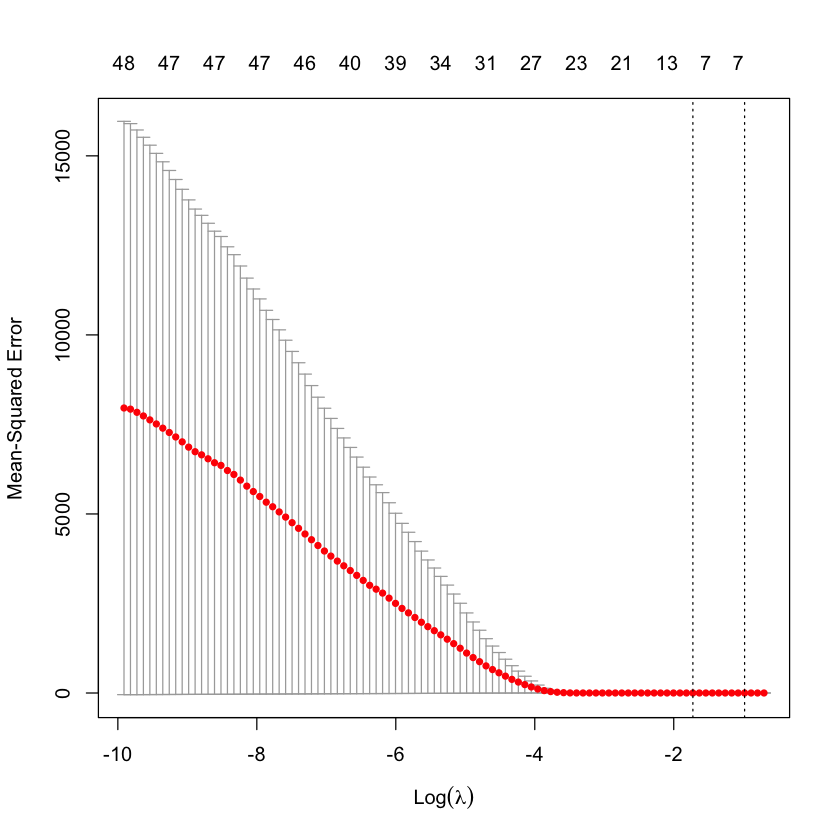

In [12]:
# Find the best alpha
best_alpha <- cv_alpha(x_train, y_train)
cat("Best alpha:", best_alpha, "\n")

# Fit the model with the best alpha
cv_model_best <- cv.glmnet(x_train, y_train, family = "gaussian", alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)
# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x_train, y_train, family = "gaussian", alpha = best_alpha, lambda = best_lambda)


### selected variables

In [13]:
lasso_coefficients <- coef(final_model_best)
# Display coefficients
print("Lasso Coefficients:")
print(lasso_coefficients)

[1] "Lasso Coefficients:"
49 x 1 sparse Matrix of class "dgCMatrix"
                                                              s0
(Intercept)                                         1.772205e+00
IT01V_packetsRecieved_ellen                         .           
IT01V_packetsRecieved_aadya                         .           
IT01V_packetsLost_ellen                             .           
IT01V_packetsLost_aadya                             .           
IT01V_frameWidth_ellen                              2.025771e-04
IT01V_frameWidth_aadya                              .           
IT01V_frameHeight_ellen                             3.759177e-04
IT01V_frameHeight_aadya                             .           
IT01V_totalFreezesDuration_ellen                    .           
IT01V_totalFreezesDuration_aadya                    .           
IT01V_framesPerSecond_ellen                         .           
IT01V_framesPerSecond_aadya                         .           
IT01V_bytesReceived_in

find pvalues by refitting a logistic model with the desired variables

In [15]:
# Isolate only the variables selected by the model
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("score_min ~", paste(selected_vars, collapse = " + ")))

# Fit a standard linear regression model
linear_model <- glm(formula, data = train_data, family = "gaussian")
summary(linear_model)



Call:
glm(formula = formula, family = "gaussian", data = train_data)

Coefficients: (1 not defined because of singularities)
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              1.371e+00  4.806e-01   2.853  0.00621
IT01V_frameWidth_ellen                   2.045e-03  2.998e-03   0.682  0.49819
IT01V_frameHeight_ellen                         NA         NA      NA       NA
IT01A_jitterBufferDelay_emissions_ellen -1.292e-03  6.762e-04  -1.910  0.06160
OT01V_packetsSent_s_ellen               -1.305e-02  4.600e-02  -0.284  0.77776
OT01V_bytesSent_in_bits_s_ellen          1.511e-06  5.003e-06   0.302  0.76382
OT01V_frameWidth_aadya                  -1.137e-03  3.043e-03  -0.374  0.71019
OT01V_framesPerSecond_ellen              2.512e-02  1.770e-02   1.419  0.16179
RIV_fractionLost_aadya                   2.431e+00  1.049e+00   2.317  0.02448
RIA_roundTripTime_aadya                 -1.090e+00  7.383e-01  -1.476  0.14588
     

predictions

In [17]:
install.packages("Metrics")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpdLXewk/downloaded_packages


MSE: 0.5153611 
MAE: 0.5887837 
R-squared: 0.4175997 


`geom_smooth()` using formula = 'y ~ x'


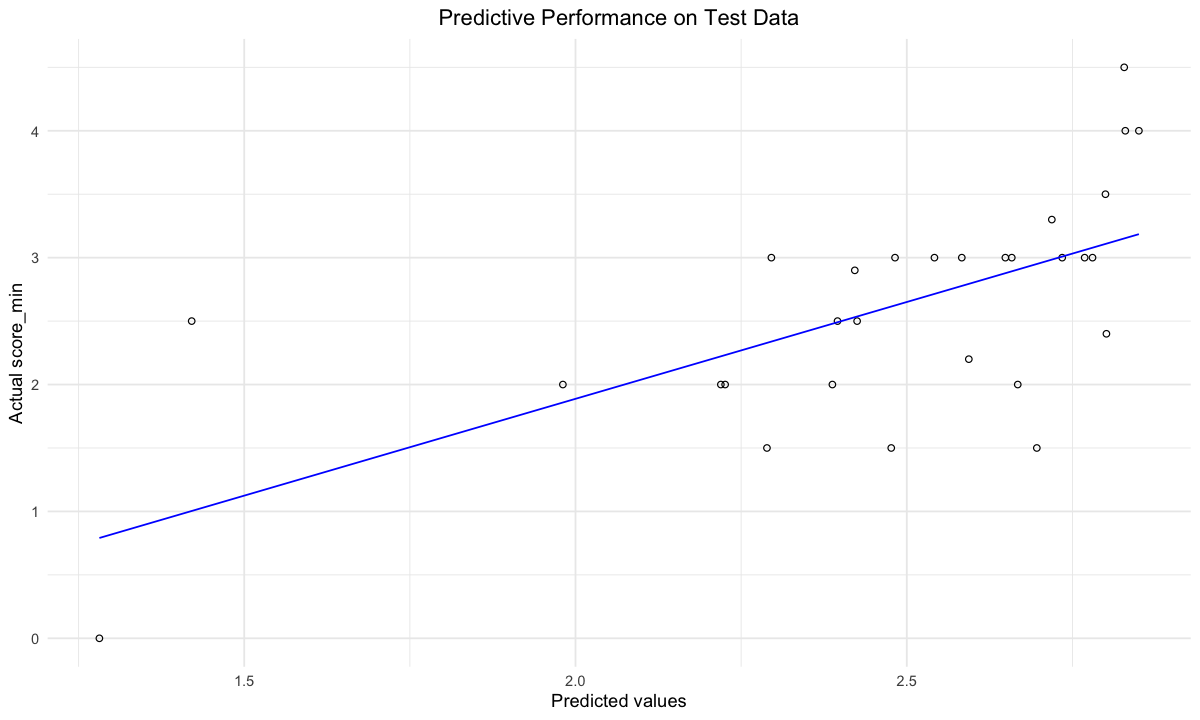

In [19]:
par(bg = "white")
options(repr.plot.width = 10, repr.plot.height = 6)

# Make predictions on the test set
predictions <- predict(final_model_best, newx = x_test)
predictions_vector <- predictions[, 1]

# Evaluate the model using MSE and R-squared
library(Metrics)  # For MSE and MAE
mse_value <- mse(y_test, predictions_vector)
mae_value <- mae(y_test, predictions_vector)
r_squared <- cor(y_test, predictions_vector)^2

cat("MSE:", mse_value, "\n")
cat("MAE:", mae_value, "\n")
cat("R-squared:", r_squared, "\n")

# Create a data frame for plotting
prediction_data <- data.frame(Actual = y_test, Predicted = predictions_vector)

# Plot the actual vs predicted values
library(ggplot2)
ggplot(prediction_data, aes(x = Predicted, y = Actual)) +
  geom_point(shape = 1, color = "black", alpha = 1) +  # Use shape 1 for empty circles
  geom_smooth(method = "lm", color = "blue", se = FALSE, linewidth = 0.5) +  # Add a linear regression line
  labs(title = "Predictive Performance on Test Data", x = "Predicted values", y = "Actual score_min") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))


# OLS

In [20]:
# Fit an OLS linear regression model
formula <- as.formula("score_min ~ .")  # Include all variables
ols_model <- lm(formula, data = train_data)

# Get summary with coefficients and p-values
summary_ols <- summary(ols_model)
print(summary_ols)



Call:
lm(formula = formula, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0082 -0.1636  0.0000  0.2140  1.0799 

Coefficients: (3 not defined because of singularities)
                                                     Estimate Std. Error
(Intercept)                                         2.778e+00  8.103e+00
IT01V_packetsRecieved_ellen                        -9.374e-02  1.248e-01
IT01V_packetsRecieved_aadya                         7.402e-02  1.244e-01
IT01V_packetsLost_ellen                            -1.123e-01  9.499e-02
IT01V_packetsLost_aadya                             5.626e-02  6.737e-02
IT01V_frameWidth_ellen                              7.971e-03  1.001e-02
IT01V_frameWidth_aadya                              1.301e-03  1.772e-03
IT01V_frameHeight_ellen                                    NA         NA
IT01V_frameHeight_aadya                                    NA         NA
IT01V_totalFreezesDuration_ellen                    1.344e-01  6.534e-01

# Step-wise

## AIC

In [ ]:
full_model <- lm(score_min ~ ., data = train_data)
fit_aic <- step(full_model)
summary(fit_aic)

predictions <- predict(fit_aic, test_data)

par(bg = "white")
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predictions, test_data$score_min, 
     main = "Prediction performance of AIC stepfit model (without outliers)", 
     xlab = "Predicted score values", ylab = "Recorded min score values", xlim = c(0,5))

# Calculate Mean Squared Error (MSE)
mse <- mean((test_data$score_min - predictions)^2)
print(mse)

## BIC

Start:  AIC=61.1
score_min ~ IT01V_packetsRecieved_ellen + IT01V_packetsRecieved_aadya + 
    IT01V_packetsLost_ellen + IT01V_packetsLost_aadya + IT01V_frameWidth_ellen + 
    IT01V_frameWidth_aadya + IT01V_frameHeight_ellen + IT01V_frameHeight_aadya + 
    IT01V_totalFreezesDuration_ellen + IT01V_totalFreezesDuration_aadya + 
    IT01V_framesPerSecond_ellen + IT01V_framesPerSecond_aadya + 
    IT01V_bytesReceived_in_bits_s_ellen + IT01V_bytesReceived_in_bits_s_aadya + 
    IT01V_totalProcessingDelay_ellen + IT01V_totalProcessingDelay_aadya + 
    IT01V_jitter_ellen + IT01V_jitter_aadya + IT01V_jitterBufferDelay_emissions_ellen + 
    IT01V_jitterBufferDelay_emissions_aadya + IT01A_bytesReceived_in_bits_s_ellen + 
    IT01A_bytesReceived_in_bits_s_aadya + IT01A_jitterBufferDelay_emissions_ellen + 
    IT01A_jitterBufferDelay_emissions_aadya + OT01V_packetsSent_s_ellen + 
    OT01V_packetsSent_s_aadya + OT01V_bytesSent_in_bits_s_ellen + 
    OT01V_bytesSent_in_bits_s_aadya + OT01V_frame


Call:
lm(formula = score_min ~ IT01V_packetsRecieved_ellen + IT01V_frameWidth_ellen + 
    IT01V_jitterBufferDelay_emissions_ellen + RIA_roundTripTime_aadya, 
    data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.10277 -0.36207  0.00665  0.40265  1.16906 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              1.4200707  0.3637657   3.904 0.000257
IT01V_packetsRecieved_ellen             -0.0189582  0.0051683  -3.668 0.000545
IT01V_frameWidth_ellen                   0.0035885  0.0007304   4.913 8.17e-06
IT01V_jitterBufferDelay_emissions_ellen -0.0023845  0.0007677  -3.106 0.002975
RIA_roundTripTime_aadya                 -2.3856980  0.6862505  -3.476 0.000989
                                           
(Intercept)                             ***
IT01V_packetsRecieved_ellen             ***
IT01V_frameWidth_ellen                  ***
IT01V_jitterBufferDelay_emissions_ellen ** 
RIA_

[1] 90.23225


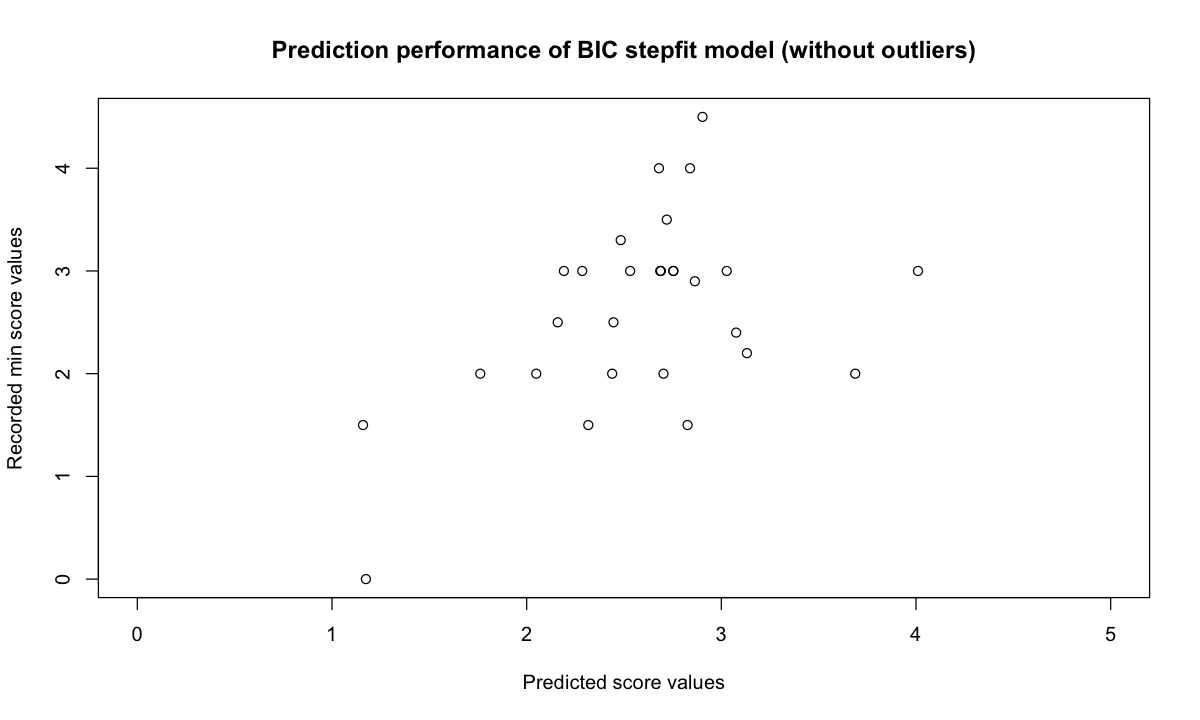

In [29]:
fit_bic<- step(full_model, k = log(length(train_data$score_min)))
summary(fit_bic)

predictions <- predict(fit_bic, test_data)

par(bg = "white")
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predictions, test_data$score_min, 
     main = "Prediction performance of BIC stepfit model (without outliers)", 
     xlab = "Predicted score values", ylab = "Recorded min score values", xlim = c(0,5))

# Calculate Mean Squared Error (MSE)
mse <- mean((test_data$score_min - predictions)^2)
print(mse)

# Non-linear methods

In [22]:
install.packages("randomForest")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpdLXewk/downloaded_packages


In [32]:
library(randomForest)
# Fit a Random Forest model
rf_model <- randomForest(score_min ~ ., data = train_data, ntree = 500)
# Make predictions
predictions_rf <- predict(rf_model, newdata = test_data)
# Evaluate the model
mse_rf <- mean((predictions_rf - test_data$score_min)^2)
cat("MSE for Random Forest:", mse_rf, "\n")


MSE for Random Forest: 0.4556615 
